In [6]:
import math
from collections import Counter
from typing import List
import numpy as np
import torch
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_score
import pandas as pd

/srv/essa-lab/flash3/cnimo3/miniconda3/envs/xlingeval/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
df = pd.read_csv("/srv/essa-lab/flash3/cnimo3/work/reproduction/AfriMedQA/AfriMed-QA/results/Llama3-OpenBioLLM-70B/Llama3-OpenBioLLM-70B_saq_base-prompt_0shot_score-0.8533_1500.csv")
df

,sample_id,question,rationale,model_prompt,outputs,ROUGE-1,ROUGE-2,ROUGE-L,BERTScore_Precision,BERTScore_Recall,BERTScore_F1
0,4fab2f40e22e1f24eb3d4770aa427cbca88d1b4ad6c905...,In what ways does the presentation of growth h...,"In developing countries, the presentation of g...",###Instruction: The following are short answer...,Developing Countries,0.000000,0.000000,0.000000,0.882730,0.823354,0.852009
1,5e29a3a9994141b38b437ecc820603d04d221ccf7a7936...,Question: Discuss the pathophysiology and clin...,Answer: Psoriasis is a chronic autoimmune skin...,###Instruction: The following are short answer...,Short Answer: Psoriasis is an inflammatory ski...,0.341667,0.110390,0.341667,0.858251,0.882245,0.870082
2,28bcc5c8405d8bf591ece1f42bab1dcaf2a5bdc6e08808...,"In African patients, what neurological disorde...","Neurocysticercosis-related epilepsy, caused by...",###Instruction: The following are short answer...,Neurological Disorder,0.000000,0.000000,0.000000,0.791804,0.772446,0.782005
3,7e2050843e7793b808680af47f907326410565629c9cd9...,"Which parasitic infection, endemic in parts of...","Schistosomiasis, caused by Schistosoma parasit...",###Instruction: The following are short answer...,The parasitic infection associated with the de...,0.538462,0.468750,0.538462,0.917864,0.928511,0.923157
4,3e29959e5b104f2b43f16a7cfcc2446934c9a1c09fb1b1...,The goal of respiration is to control the conc...,"Oxygen, carbon dioxide and hydrogen ions \r\nR...",###Instruction: The following are short answer...,Respiration aims to control the concentration ...,0.354839,0.078947,0.290323,0.850687,0.868429,0.859467
...,...,...,...,...,...,...,...,...,...,...,...
1495,a8355d99bf5ff26ae82b176ee6e6bfa5180d552c61297e...,What is the most common cause of abnormal uter...,"Uterine fibroids, also known as leiomyomas, ar...",###Instruction: The following are short answer...,Most Common Cause,0.000000,0.000000,0.000000,0.819448,0.744440,0.780145
1496,2c85e4cb7467681fcd1d12f3ffc8a3d864aaac94ca1039...,What is the primary cause of chronic cough in ...,Tuberculosis (TB) is the primary cause of chro...,###Instruction: The following are short answer...,Primary Cause,0.000000,0.000000,0.000000,0.821504,0.743644,0.780638
1497,db0a86b6c675110e2bebc6c4294df3ff68c260a784ce13...,What is the primary method used for diagnosing...,Hemoglobin electrophoresis is the primary meth...,###Instruction: The following are short answer...,The primary method used for diagnosing hemoglo...,0.466667,0.281250,0.333333,0.902173,0.920837,0.911409
1498,efb01139d88c7aeca90647dbd795968fee534aae192426...,What is the primary cause of acute respiratory...,Respiratory syncytial virus (RSV) is the prima...,###Instruction: The following are short answer...,Pneumococcal pneumonia is the primary cause of...,0.466667,0.417910,0.466667,0.941121,0.875863,0.907320


In [8]:
outputs_list = df.iloc[:20]['outputs']
rationale_list = df.iloc[:20]['rationale']
outputs_list[0]
rationale_list

0     In developing countries, the presentation of g...
1     Answer: Psoriasis is a chronic autoimmune skin...
2     Neurocysticercosis-related epilepsy, caused by...
3     Schistosomiasis, caused by Schistosoma parasit...
4     Oxygen, carbon dioxide and hydrogen ions \r\nR...
5     Borreliosis, caused by Borrelia burgdorferi ba...
6     The etiology of IC/BPS remains incompletely un...
7     Yes, this follows the logical definition of a ...
8     In Africa, laryngeal cancer is more commonly a...
9     Diabetic nephropathy, characterized by glomeru...
10    Obsessive-compulsive disorder (OCD). The obses...
11    Bronchiectasis is characterized by irreversibl...
12    Azithromycin is the recommended first-line tre...
13    Factors such as a diet high in salted or smoke...
14    Topical paromomycin is the recommended first-l...
15    Traditional birth attendants (TBAs) play a cru...
16    Migraine aura typically presents with visual d...
17    Around 10-15%.It’s estimated that 10-15% o

In [4]:
def compute_lexical_similarity(s1: str, s2: str, unigram_probabilities: dict):
    # Create sets of the words in the snippets
    s1_words = set(s1.split())
    s2_words = set(s2.split())

    # Compute the intersection (common words) and union (all words) of the two sets
    common_words = s1_words & s2_words

    # Consider unique words only
    all_words = s1_words | s2_words

    # Consider all words, including repeated ones
    # all_words = list(s1_words) + list(s2_words)

    # Compute the log probability weighted sum of the common words
    common_sum = sum(
        [math.log(unigram_probabilities[word]) for word in common_words if
         word in unigram_probabilities])

    # Compute the log probability weighted sum of all the words
    all_sum = sum(
        [math.log(unigram_probabilities[word]) for word in all_words if
         word in unigram_probabilities])

    # Compute the lexical similarity
    sim_l = (2 * common_sum) / all_sum if all_sum else 0

    return sim_l

In [11]:
import nltk
from collections import Counter
import string

nltk.data.path[0]="/srv/essa-lab/flash3/cnimo3/work/reproduction/PMC-LLaMA/consistency/nltk_data"

In [6]:
nltk.download('punkt', download_dir="/srv/essa-lab/flash3/cnimo3/work/reproduction/PMC-LLaMA/consistency/nltk_data")
nltk.download('stopwords', download_dir="/srv/essa-lab/flash3/cnimo3/work/reproduction/PMC-LLaMA/consistency/nltk_data")

[nltk_data] Downloading package punkt to /srv/essa-
[nltk_data]     lab/flash3/cnimo3/work/reproduction/PMC-
[nltk_data]     LLaMA/consistency/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /srv/essa-
[nltk_data]     lab/flash3/cnimo3/work/reproduction/PMC-
[nltk_data]     LLaMA/consistency/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
import os
os.environ["NLTK_DATA "] = "/srv/essa-lab/flash3/cnimo3/work/reproduction/PMC-LLaMA/consistency/nltk_data"

In [8]:
corpus = df['rationale']
corpus

0       In developing countries, the presentation of g...
1       Answer: Psoriasis is a chronic autoimmune skin...
2       Neurocysticercosis-related epilepsy, caused by...
3       Schistosomiasis, caused by Schistosoma parasit...
4       Oxygen, carbon dioxide and hydrogen ions \r\nR...
                              ...                        
1495    Uterine fibroids, also known as leiomyomas, ar...
1496    Tuberculosis (TB) is the primary cause of chro...
1497    Hemoglobin electrophoresis is the primary meth...
1498    Respiratory syncytial virus (RSV) is the prima...
1499    The healthcare system may provide services suc...
Name: rationale, Length: 1500, dtype: object

In [9]:
def preprocess_string(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text.lower())
    # Remove stopwords
    stopwords = set(nltk.corpus.stopwords.words('english'))
    # Remove punctuation and non-alphabetic tokens
    processed_tokens = [word for word in tokens if word.isalpha() and word not in stopwords]
    return processed_tokens

In [10]:
all_tokens = []
for text in corpus:
    all_tokens.extend(preprocess_string(text))

In [12]:
# Step 3: Count the frequencies of each word
word_freq = Counter(all_tokens)

# Total number of words in the corpus after preprocessing
total_words = sum(word_freq.values())

# Step 4: Calculate unigram probabilities
unigram_probabilities = {word: freq / total_words for word, freq in word_freq.items()}

In [13]:
for word, prob in unigram_probabilities.items():
    print(f"Word: {word}, Probability: {prob:.6f}")

Word: developing, Probability: 0.000468
Word: countries, Probability: 0.001588
Word: presentation, Probability: 0.000652
Word: growth, Probability: 0.000485
Word: hormone, Probability: 0.000502
Word: deficiency, Probability: 0.001020
Word: may, Probability: 0.007690
Word: overshadowed, Probability: 0.000017
Word: malnutrition, Probability: 0.001003
Word: infectious, Probability: 0.000769
Word: diseases, Probability: 0.002123
Word: leading, Probability: 0.002725
Word: delayed, Probability: 0.000385
Word: diagnosis, Probability: 0.002675
Word: treatment, Probability: 0.005818
Word: additionally, Probability: 0.000669
Word: socioeconomic, Probability: 0.000284
Word: factors, Probability: 0.003695
Word: limit, Probability: 0.000100
Word: access, Probability: 0.004915
Word: replacement, Probability: 0.000184
Word: therapy, Probability: 0.002457
Word: answer, Probability: 0.002508
Word: psoriasis, Probability: 0.000084
Word: chronic, Probability: 0.002725
Word: autoimmune, Probability: 0.000

In [53]:
index = 3
lex_sim = compute_lexical_similarity(outputs_list[index], rationale_list[index], unigram_probabilities )

print(f"Lexical Similarity:  {lex_sim}")
print(f"LLM Answer: {outputs_list[index]}")
print(f"Ground Truth: {rationale_list[index]}")

Lexical Similarity:  0.946045057047669
LLM Answer: The parasitic infection associated with the development of eosinophilia and hypereosinophilic syndrome is Schistosomiasis. This condition is endemic in parts of Africa and is known to cause an increase in eosinophil count in the blood, which can lead to the development of hypereosinophilic syndrome.
Ground Truth: Schistosomiasis, caused by Schistosoma parasites, is endemic in parts of Africa and is associated with the development of eosinophilia and hypereosinophilic syndrome in some individuals.


In [ ]:
def jaccard_sim(text1: str, text2: str, ngram: int = 1) -> float:
    # Create the CountVectorizer object. Note that `binary=True` so we only care about the presence of each word but not #times it appears
    vectorizer = CountVectorizer(ngram_range=(ngram, ngram), binary=True)

    # Create the document-term matrix
    dtm = vectorizer.fit_transform([text1, text2]).toarray()

    # Calculate the Jaccard similarity
    return jaccard_score(dtm[0], dtm[1])

In [34]:
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [52]:
index = 3
jacc_sim = jaccard_similarity(outputs_list[index], rationale_list[index])
print(jacc_sim)
print(f"Jaccard Similarity:  {jacc_sim}")
print(f"LLM Answer: {outputs_list[index]}")
print(f"Ground Truth: {rationale_list[index]}")

0.9259259259259259
Jaccard Similarity:  0.9259259259259259
LLM Answer: The parasitic infection associated with the development of eosinophilia and hypereosinophilic syndrome is Schistosomiasis. This condition is endemic in parts of Africa and is known to cause an increase in eosinophil count in the blood, which can lead to the development of hypereosinophilic syndrome.
Ground Truth: Schistosomiasis, caused by Schistosoma parasites, is endemic in parts of Africa and is associated with the development of eosinophilia and hypereosinophilic syndrome in some individuals.


In [38]:
index = 10
jacc_score = jaccard_score(outputs_list[index], rationale_list[index])

ValueError: Found input variables with inconsistent numbers of samples: [351, 143]

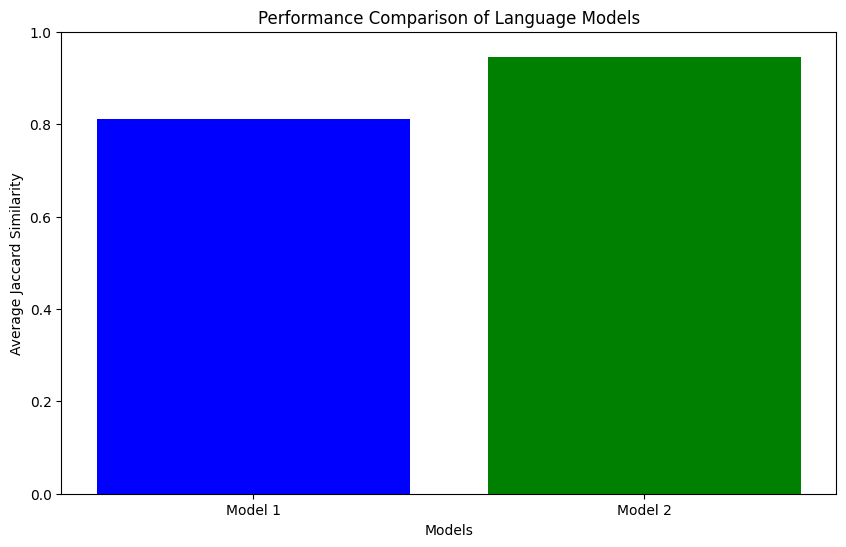

In [54]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt

def jaccard_similarity(text1, text2):
    vectorizer = CountVectorizer(binary=True)
    vectors = vectorizer.fit_transform([text1, text2]).toarray()
    return jaccard_score(vectors[0], vectors[1])

# Example datasets (replace with your actual data)
ground_truth = [
    "The cat is on the mat",
    "There is a dog in the yard",
    "The sky is blue",
]

generated_answers_model1 = [
    "The cat is on the mat",
    "A dog is in the yard",
    "The sky is clear",
]

generated_answers_model2 = [
    "The cat is sleeping on the mat",
    "There is a dog in the yard",
    "The sky is blue",
]

models = {
    "Model 1": generated_answers_model1,
    "Model 2": generated_answers_model2,
}

# Compute Jaccard similarity for each model
results = {}
for model_name, generated_answers in models.items():
    similarities = []
    for gt, ga in zip(ground_truth, generated_answers):
        similarity = jaccard_similarity(gt, ga)
        similarities.append(similarity)
    results[model_name] = np.mean(similarities)

# Plot the results
model_names = list(results.keys())
jaccard_similarities = list(results.values())

plt.figure(figsize=(10, 6))
plt.bar(model_names, jaccard_similarities, color=['blue', 'green'])
plt.xlabel('Models')
plt.ylabel('Average Jaccard Similarity')
plt.title('Performance Comparison of Language Models')
plt.ylim(0, 1)
plt.show()

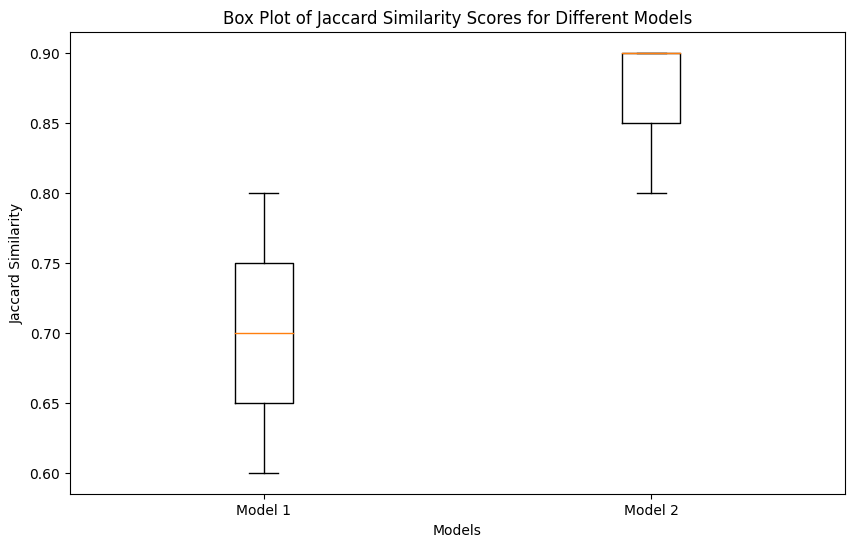

In [55]:
import matplotlib.pyplot as plt

# Sample Jaccard similarities for each model (replace with actual data)
similarities_model1 = [0.8, 0.6, 0.7]
similarities_model2 = [0.9, 0.8, 0.9]

data = [similarities_model1, similarities_model2]
model_names = ["Model 1", "Model 2"]

plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=model_names)
plt.xlabel('Models')
plt.ylabel('Jaccard Similarity')
plt.title('Box Plot of Jaccard Similarity Scores for Different Models')
plt.show()

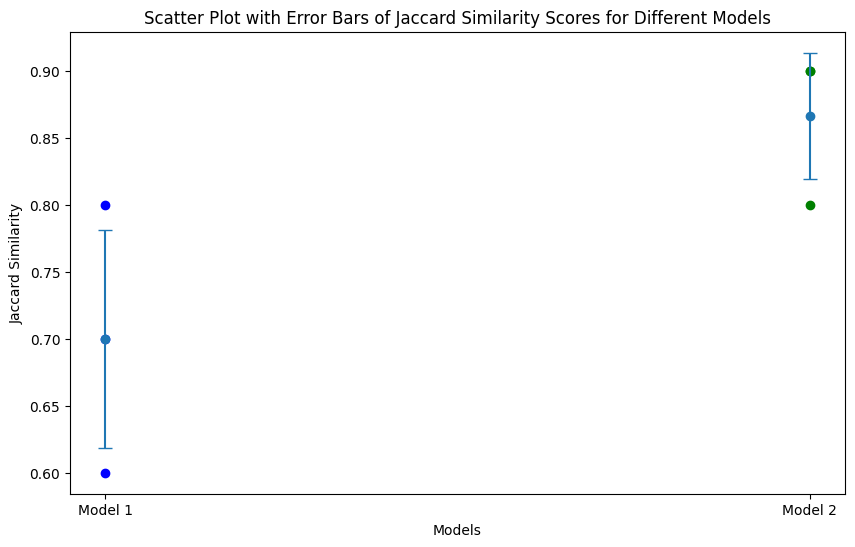

In [56]:
import numpy as np

# Sample data (replace with actual data)
similarities_model1 = [0.8, 0.6, 0.7]
similarities_model2 = [0.9, 0.8, 0.9]

means = [np.mean(similarities_model1), np.mean(similarities_model2)]
std_devs = [np.std(similarities_model1), np.std(similarities_model2)]
model_names = ["Model 1", "Model 2"]

plt.figure(figsize=(10, 6))
plt.errorbar(model_names, means, yerr=std_devs, fmt='o', capsize=5)
plt.scatter(["Model 1"] * len(similarities_model1), similarities_model1, color='blue')
plt.scatter(["Model 2"] * len(similarities_model2), similarities_model2, color='green')
plt.xlabel('Models')
plt.ylabel('Jaccard Similarity')
plt.title('Scatter Plot with Error Bars of Jaccard Similarity Scores for Different Models')
plt.show()

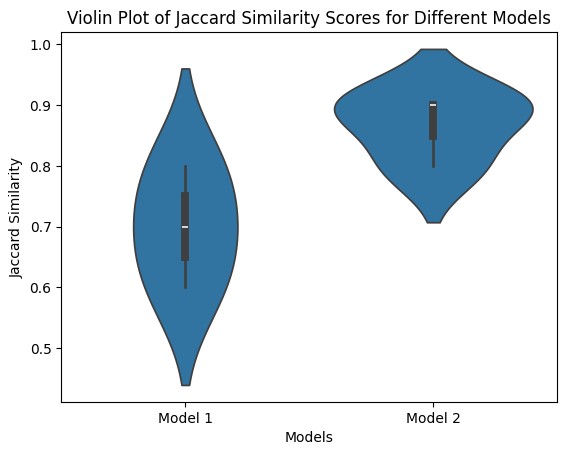

In [57]:
import seaborn as sns

# Sample data preparation (replace with actual data)
similarities_model1 = [0.8, 0.6, 0.7]
similarities_model2 = [0.9, 0.8, 0.9]

data = {
    "Model": ["Model 1"] * len(similarities_model1) + ["Model 2"] * len(similarities_model2),
    "Jaccard Similarity": similarities_model1 + similarities_model2
}

# Using seaborn for violin plot
sns.violinplot(x="Model", y="Jaccard Similarity", data=data)
plt.xlabel('Models')
plt.ylabel('Jaccard Similarity')
plt.title('Violin Plot of Jaccard Similarity Scores for Different Models')
plt.show()

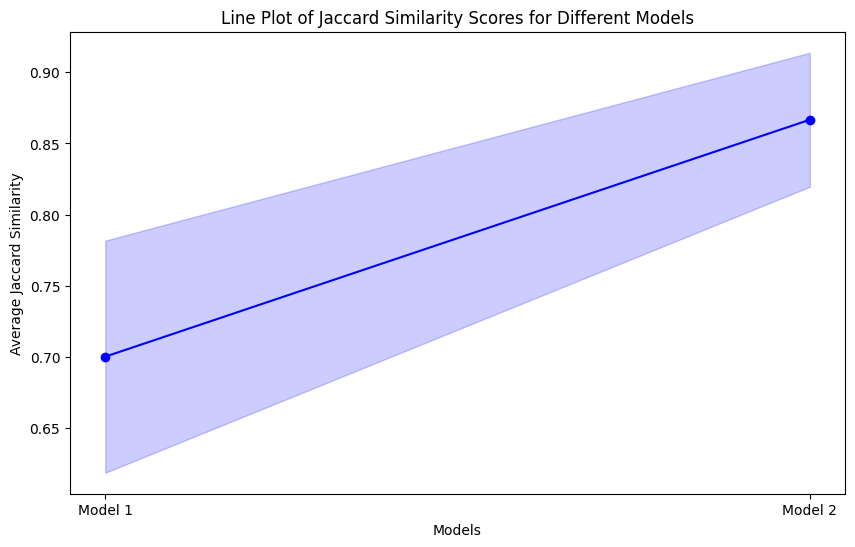

In [58]:
plt.figure(figsize=(10, 6))

# Sample means (replace with actual data)
means = [np.mean(similarities_model1), np.mean(similarities_model2)]
std_devs = [np.std(similarities_model1), np.std(similarities_model2)]
model_names = ["Model 1", "Model 2"]

plt.plot(model_names, means, marker='o', linestyle='-', color='blue')
plt.fill_between(model_names, np.array(means) - np.array(std_devs), np.array(means) + np.array(std_devs), color='blue', alpha=0.2)

plt.xlabel('Models')
plt.ylabel('Average Jaccard Similarity')
plt.title('Line Plot of Jaccard Similarity Scores for Different Models')
plt.show()

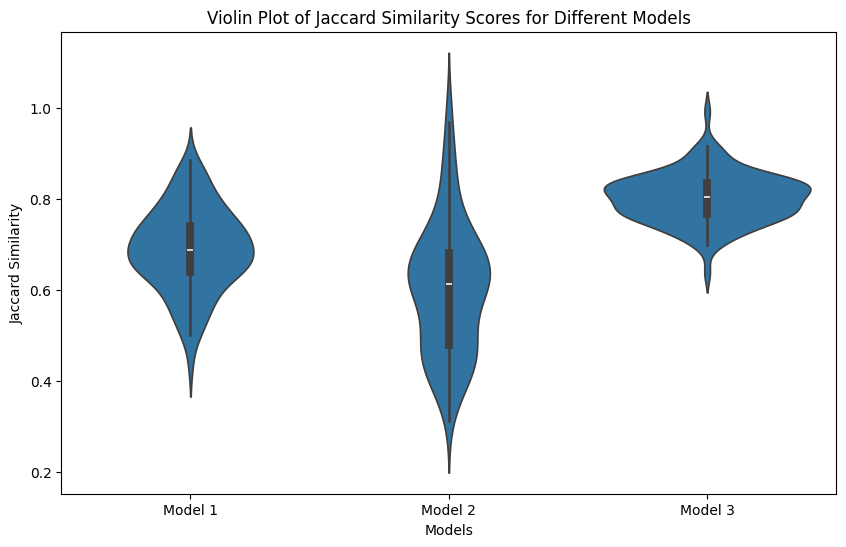

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate synthetic data
np.random.seed(42)
similarities_model1 = np.random.normal(0.7, 0.1, 100)
similarities_model2 = np.random.normal(0.6, 0.15, 100)
similarities_model3 = np.random.normal(0.8, 0.05, 100)

data = {
    "Model": ["Model 1"] * len(similarities_model1) + ["Model 2"] * len(similarities_model2) + ["Model 3"] * len(similarities_model3),
    "Jaccard Similarity": list(similarities_model1) + list(similarities_model2) + list(similarities_model3)
}

# Violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x="Model", y="Jaccard Similarity", data=data)
plt.xlabel('Models')
plt.ylabel('Jaccard Similarity')
plt.title('Violin Plot of Jaccard Similarity Scores for Different Models')
plt.show()


In [4]:
def tokenize(text):
    # Tokenize the text by splitting on whitespace and removing punctuation
    return set(text.lower().split())

def overlap_similarity(text1, text2):
    # Convert texts to sets of unique words
    set1 = tokenize(text1)
    set2 = tokenize(text2)
    
    # Compute the intersection of the sets
    intersection = set1.intersection(set2)
    
    # Compute the overlap similarity
    overlap_sim = len(intersection) / min(len(set1), len(set2))
    
    return overlap_sim

# Example usage
text1 = "The quick brown fox jumps over the lazy dog"
text2 = "The quick brown dog jumps over the lazy fox"
similarity = overlap_similarity(text1, text2)
print(f"Overlap similarity: {similarity:.4f}")


Overlap similarity: 1.0000


In [9]:
index = 3
cos_sim = overlap_similarity(outputs_list[index], rationale_list[index])
print(cos_sim)
print(f"Cosine Similarity:  {cos_sim}")
print(f"LLM Answer: {outputs_list[index]}")
print(f"Ground Truth: {rationale_list[index]}")

0.6666666666666666
Cosine Similarity:  0.6666666666666666
LLM Answer: The parasitic infection associated with the development of eosinophilia and hypereosinophilic syndrome is Schistosomiasis. This condition is endemic in parts of Africa and is known to cause an increase in eosinophil count in the blood, which can lead to the development of hypereosinophilic syndrome.
Ground Truth: Schistosomiasis, caused by Schistosoma parasites, is endemic in parts of Africa and is associated with the development of eosinophilia and hypereosinophilic syndrome in some individuals.


In [10]:
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Ensure you have the necessary NLTK data files
import nltk
nltk.download('punkt')
nltk.download('stopwords')

def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    return set(tokens)

def dice_similarity(text1, text2):
    # Preprocess texts
    set1 = preprocess(text1)
    set2 = preprocess(text2)
    
    # Compute the intersection of the sets
    intersection = set1.intersection(set2)
    
    # Compute the Dice similarity
    dice_sim = 2 * len(intersection) / (len(set1) + len(set2))
    
    return dice_sim

# Example usage
text1 = "The quick brown fox jumps over the lazy dog"
text2 = "The quick brown dog jumps over the lazy fox"
similarity = dice_similarity(text1, text2)
print(f"Dice similarity: {similarity:.4f}")


Dice similarity: 1.0000


[nltk_data] Downloading package punkt to /nethome/cnimo3/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /nethome/cnimo3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
index = 3
dice_sim = dice_similarity(outputs_list[index], rationale_list[index])
print(dice_sim)
print(f"Cosine Similarity:  {dice_sim}")
print(f"LLM Answer: {outputs_list[index]}")
print(f"Ground Truth: {rationale_list[index]}")

0.5625
Cosine Similarity:  0.5625
LLM Answer: The parasitic infection associated with the development of eosinophilia and hypereosinophilic syndrome is Schistosomiasis. This condition is endemic in parts of Africa and is known to cause an increase in eosinophil count in the blood, which can lead to the development of hypereosinophilic syndrome.
Ground Truth: Schistosomiasis, caused by Schistosoma parasites, is endemic in parts of Africa and is associated with the development of eosinophilia and hypereosinophilic syndrome in some individuals.
